# North Atlantic histograms

# 1) Make histogram of each term 

In [34]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(15)
client = cluster.get_client()

In [35]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.281c0e91d36544559ac809e956ea520c/status,


In [2]:
cluster.close()
client.close()

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
import gsw
from xhistogram.xarray import histogram

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
cesm  = cat["CESM_POP_hires_control"].to_dask()

In [3]:
#Load in tendencies

import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [4]:
tracers = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/tracer_tendencies_40yr.zarr'))
drhodts = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/drhodts_tendencies_40yr.zarr'))
rho_cab = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/rho_bih_cab_tendencies_40yr.zarr'))

tendencies = xr.merge([tracers, drhodts, rho_cab])

In [5]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 14965, nlat: 2400, nlon: 3600)
Coordinates:
  * nlat       (nlat) int64 0 1 2 3 4 5 6 ... 2393 2394 2395 2396 2397 2398 2399
  * nlon       (nlon) int64 0 1 2 3 4 5 6 ... 3593 3594 3595 3596 3597 3598 3599
  * time       (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Data variables:
    SSS_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhods     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhodt     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

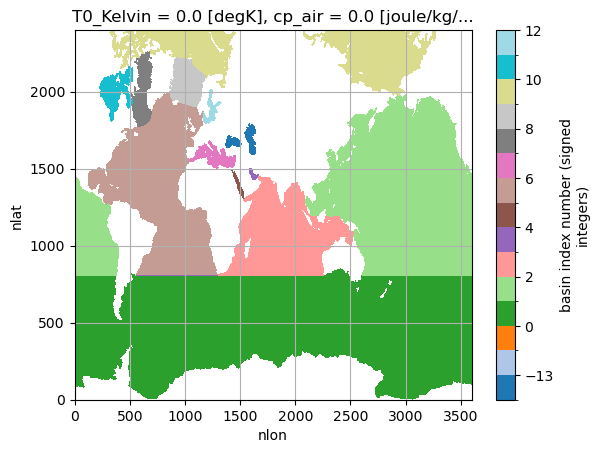

In [30]:
regions = np.unique(cesm.REGION_MASK)
cesm.REGION_MASK.where(cesm.KMT>0).plot.contourf(levels=regions, cmap='tab20')
plt.grid();

In [6]:
#assign each region index value to basin name

caspian_sea = -14
black_sea = -13
#unknown = -1
#unknown = 0
southern_ocean = 1
pacific_ocean = 2
indian_ocean = 3
persian_gulf = 4
red_sea = 5
atlantic_ocean = 6
med_sea = 7
lab_sea = 8
norwegian_sea = 9
arctic_ocean = 10
hudson_bay = 11
baltic_sea = 12

#combining atl, lab and norwegian sea masks together
nor_bool = cesm.REGION_MASK.where(cesm.REGION_MASK==9).notnull()
lab_bool = cesm.REGION_MASK.where(cesm.REGION_MASK==8).notnull()
atl_bool = cesm.REGION_MASK.where(cesm.REGION_MASK==6).notnull()

atl_mask = (nor_bool+lab_bool+atl_bool)

In [7]:
mask = cesm.REGION_MASK.reset_coords(drop=True)

In [8]:
#New ds after dthetadt*drhodt and dSdt*drhods
def new_ds(ds):
    newds = xr.merge([(ds['SST_bih']*ds['drhodt']).rename('sst'),
                      (ds['SSS_bih']*ds['drhods']).rename('sss'),
                       ds['rho_bih'].rename('rho'),
                       ds['cabbeling']])
    return newds

In [9]:
tend = new_ds(tendencies)

In [10]:
tend

<xarray.Dataset>
Dimensions:    (nlat: 2400, nlon: 3600, time: 14965)
Coordinates:
  * nlat       (nlat) int64 0 1 2 3 4 5 6 ... 2393 2394 2395 2396 2397 2398 2399
  * nlon       (nlon) int64 0 1 2 3 4 5 6 ... 3593 3594 3595 3596 3597 3598 3599
  * time       (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Data variables:
    sst        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    sss        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

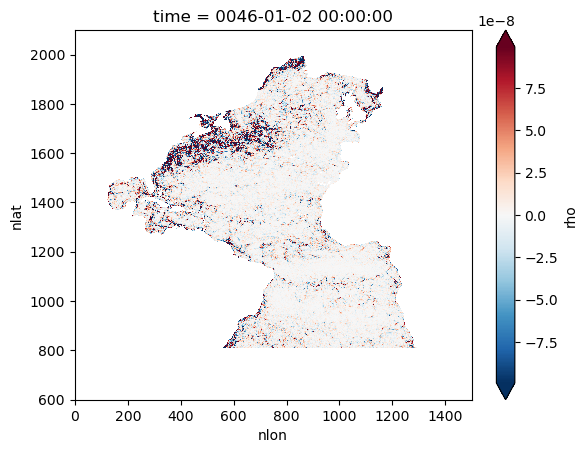

In [14]:
tend.rho.where(mask==atlantic_ocean).isel(time=0).isel(nlon=slice(0, 1500), nlat=slice(600, 2100)).plot(robust=True)

In [13]:
sa = gsw.SA_from_SP(cesm.SSS, 10.1325, cesm.nlon, cesm.nlat)
ct = gsw.CT_from_pt(sa, cesm.SST)

#rmask = mask
#mask_bins = np.arange(rmask.min()-0.5, rmask.max()+0.5)
#mask_bins = np.array([-14.5, -13.5,  -1.5,   0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   
#                      6.5,   7.5, 8.5,   9.5,  10.5,  11.5,  12.5])
rho1 = gsw.sigma0(sa, ct).rename('rho')
rho = gsw.sigma0(cesm.SSS, cesm.SST).rename('rho')

In [15]:
delta_rho = 0.1
rho_bins = np.arange(15, 35, delta_rho)

In [16]:
rho_bins[119] #26.95 is the most frequently occurring density from surf_diabatic layer

26.899999999999956

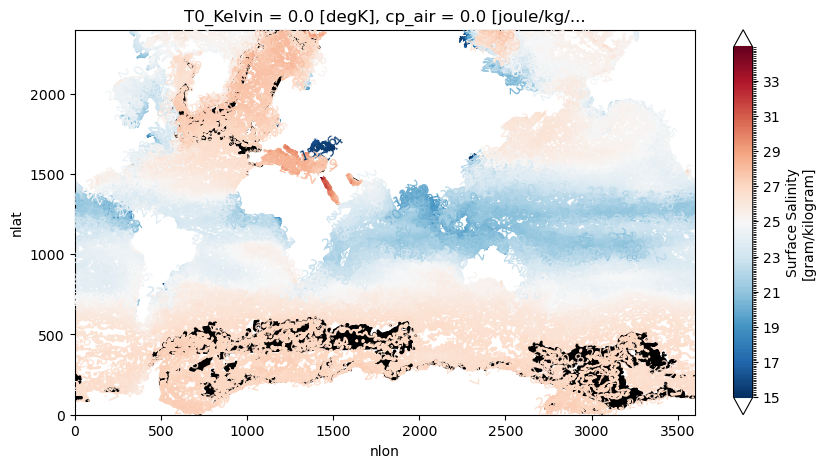

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
C = rho[0].plot.contour(levels=rho_bins, ax=ax, add_colorbar=True)
C.collections[119].set_color('k')
C.collections[119].set_linewidth(1.5)
plt.clabel(C);

# Split the tendencies to NATL basin

In [25]:
all_tendencies = list(tend)

In [20]:
def basin_selection(tend_term, basin):
    tendency_in_basin = tend_term.where(ds.REGION_MASK==basin)
    return tendency_in_basin

In [49]:
#Atlantic Ocean
atl_ocean = xr.merge([tend[var].where(atl_mask).rename(var) for var in all_tendencies])

In [50]:
atl_ocean

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965)
Coordinates: (12/54)
  * nlat                (nlat) int64 0 1 2 3 4 5 ... 2395 2396 2397 2398 2399
  * nlon                (nlon) int64 0 1 2 3 4 5 ... 3595 3596 3597 3598 3599
  * time                (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:0...
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    salt_to_ppt         float64 0.0
    sea_ice_salinity    float64 0.0
    sflux_factor        float64 0.0
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
    vonkar              float64 0.0
Data variables:
    sst                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    sss                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling           (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [53]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.281c0e91d36544559ac809e956ea520c/status,


In [ ]:
atl_ocean.rho.plot(robust=True)

# NATL histogram

In [18]:
avg_mld = (cesm.HMXL_2*1e-2).mean('time').compute()
cm2_to_m2 = 1e-4
weights = cesm.TAREA*cm2_to_m2*avg_mld

In [54]:
atl_hist = xr.merge([(histogram(rho.where(atl_mask), 
                               bins=[rho_bins], 
                               weights=(atl_ocean[var].fillna(0.)*weights.where(atl_mask)), 
                               dim=['nlon']) / delta_rho) for var in all_tendencies])

Task exception was never retrieved
future: <Task finished name='Task-248636' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248637' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248638' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/li

CommClosedError: in <TLS (closed) ConnectionPool.gather local=tls://10.0.80.3:53630 remote=gateway://traefik-prod-dask-gateway.prod:80/prod.281c0e91d36544559ac809e956ea520c>: Stream is closed

In [56]:
atl_hist

NameError: name 'atl_hist' is not defined